**Module Paths**

In [1]:
import sys

sys.path.append("../../../")

# Importing necessary modules

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import DataLoader
from typing import Tuple
from data import DatasetWrapper, DataLoaderWrapper
from criterion import CriterionWrapper
from optimize import OptimizerWrapper
from trainer import CNNTrainer
from data.helper import calculate_mean_std
from utils.device import get_device

# CNN

In [3]:
device = get_device()

## Define the CNN model

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(
            64 * 7 * 7, 128
        )  # Adjusted to match the flattened size after pooling
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))  # First conv layer and pooling
        x = self.pool(F.relu(self.conv2(x)))  # Second conv layer and pooling

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Load the Data

First, initialize without normalization to calculate mean and std

In [5]:
initial_transform = T.Compose([T.ToTensor()])

Create a dataset for calculating mean and std

In [6]:
dataset_wrapper = DatasetWrapper(
    dataset_name="MNIST",
    root="./data",
    train_transform=initial_transform,
    download=True,
)
train_dataset, _, _ = dataset_wrapper.get_datasets()

In [7]:
mean, std = calculate_mean_std(train_dataset, device=device)
print("Calculated Mean:", mean)
print("Calculated Std:", std)

Calculated Mean: tensor([0.1306])
Calculated Std: tensor([0.3015])


Now update the transforms to include normalization

In [8]:
train_transforms = T.Compose(
    [
        # Apply random affine transformations with rotation and translation for off-center positioning
        T.RandomAffine(degrees=15, translate=(0.3, 0.3)),
        # Apply a small amount of Gaussian blur to introduce blur variability
        T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        # Convert to tensor and normalize with calculated mean and std
        T.ToTensor(),
        T.Normalize(mean.tolist(), std.tolist()),
    ]
)

Update Dataset with normalized transforms

In [9]:
dataset_wrapper = DatasetWrapper(
    dataset_name="MNIST", root="./data", train_transform=train_transforms, download=True
)

## Create DataLoader

In [10]:
train_dataset, val_dataset, _ = dataset_wrapper.get_datasets()

train_loader_wrapper = DataLoaderWrapper(
    dataset=train_dataset, batch_size=64, shuffle=True
)
val_loader_wrapper = DataLoaderWrapper(
    dataset=val_dataset, batch_size=64, shuffle=False
)

train_loader = train_loader_wrapper.get_loader()
val_loader = val_loader_wrapper.get_loader()

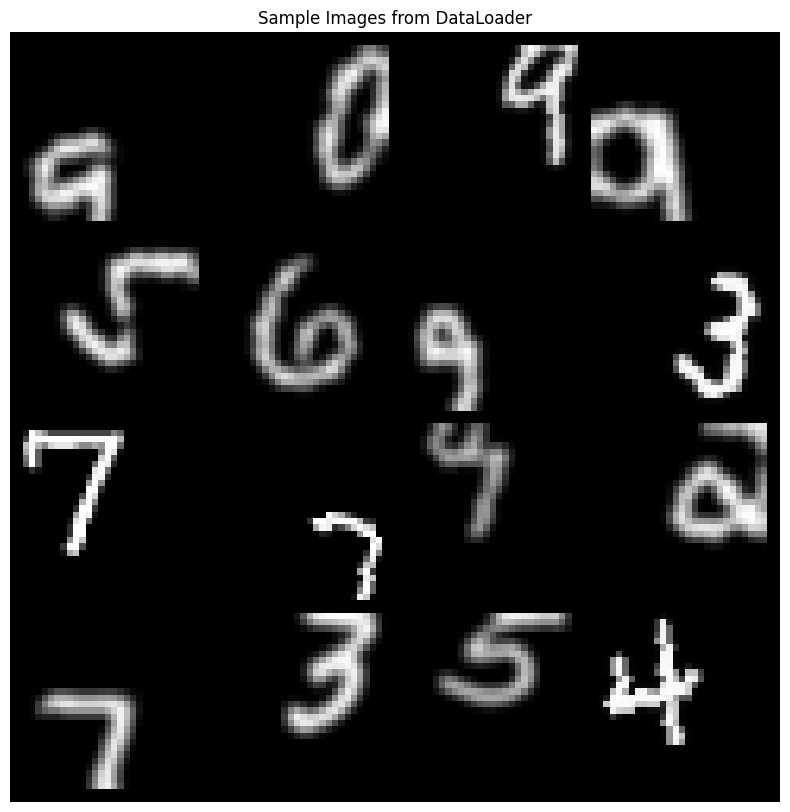

In [11]:
train_loader_wrapper.display_sample_images()

## Initialize model, criterion, optimizer

In [12]:
# Model
model = CNN()

# Criterion
criterion_wrapper = CriterionWrapper(criterion_name="cross_entropy")
criterion = criterion_wrapper.get_criterion()

# Optimizer
optimizer_wrapper = OptimizerWrapper(model=model, optimizer_name="adam", lr=0.001)
optimizer = optimizer_wrapper.get_optimizer()

## Train the model

In [13]:
trainer = CNNTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
)

In [14]:
# Train the model for a few epochs
trainer.train(num_epochs=5, save_path="./best_cnn_mnist_model.pth.local")

Epoch 1/5, Train Loss: 0.6647, Val Loss: 0.3482, Val Accuracy: 89.05%
Best model saved with val loss: 0.3482
Epoch 2/5, Train Loss: 0.2598, Val Loss: 0.2212, Val Accuracy: 93.58%
Best model saved with val loss: 0.2212
Epoch 3/5, Train Loss: 0.1999, Val Loss: 0.1786, Val Accuracy: 94.42%
Best model saved with val loss: 0.1786
Epoch 4/5, Train Loss: 0.1697, Val Loss: 0.1719, Val Accuracy: 94.66%
Best model saved with val loss: 0.1719
Epoch 5/5, Train Loss: 0.1494, Val Loss: 0.1332, Val Accuracy: 95.94%
Best model saved with val loss: 0.1332


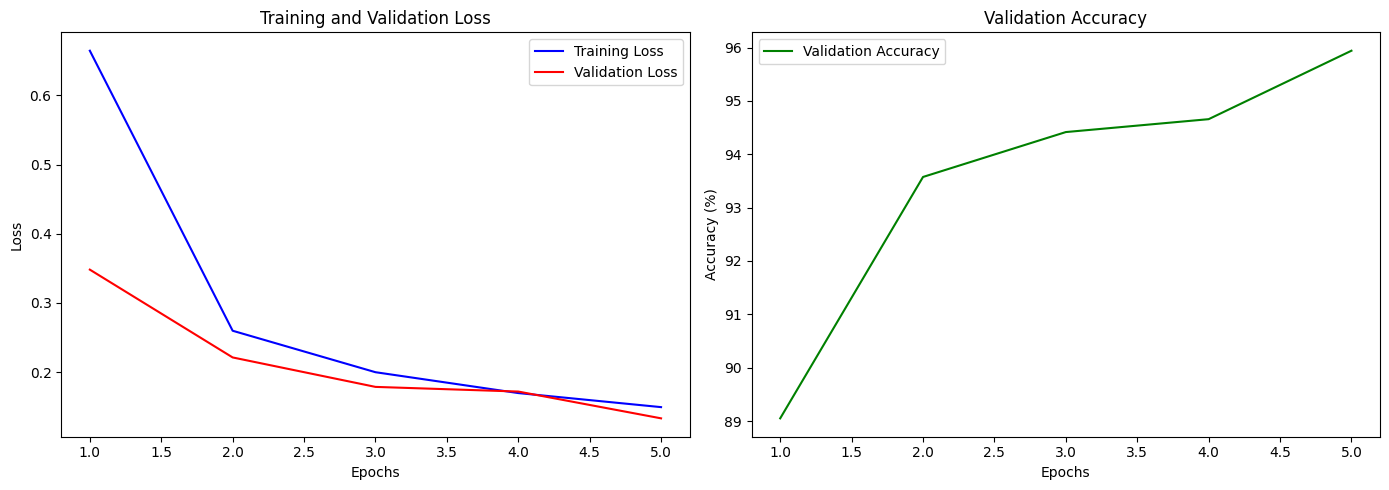

In [15]:
# Plot the trainer metrics
trainer.plot_metrics()

The CNN model performed noticeably better than the MLP model on the transformed MNIST data, achieving both a lower validation loss and higher accuracy over the same number of epochs. This improvement can be attributed to the following reasons:

	1.	Spatial Feature Extraction: Convolutional layers excel at detecting local spatial patterns, which is particularly beneficial with the applied transformations that make digit positioning less predictable. Unlike the MLP, which treats every pixel independently, the CNN effectively captures localized patterns and hierarchies, which helps it generalize better on these variations.
	2.	Translation and Scale Invariance: The CNN’s convolutional and pooling layers offer some degree of translation and scale invariance. This is essential with the off-center transformations, where digits can appear in various positions within the frame. The pooling layers help the CNN focus on the most relevant features by reducing spatial dimensions, making it less sensitive to slight shifts or scale changes.
	3.	Efficient Parameter Usage: By using shared filters across the input, the CNN has fewer parameters compared to an MLP with similar capacity. This shared-weight structure enables the CNN to learn spatially relevant features without overfitting, which is especially useful for handling noise and transformations introduced during data augmentation.
	4.	Hierarchical Feature Learning: The CNN’s layered structure allows it to learn low-level features (like edges) in the early layers and combine them into more complex patterns in the deeper layers. This hierarchical approach to feature learning is naturally suited to image data and helps the CNN model distinguish between digits even with the added noise and variations.